# Guide to realibility digram script

## Summary

This script (onset_reliability_diagram_cmz.py) evaluates the reliability of probabilsitic monsoon onset forecast compared against IMD (India Meteorological Department) observations over the Core Monsoon Zone (CMZ).

### Context

This tool performs reliability analysis by comparing ensemble forecast probabilities with observed monsoon onset events, generating reliability diagrams that show how well forecast probabilities correspond to actual occurrence frequencies.

## Script Details

### Data Flow

Input Data:
- Model data: NetCDF files with precipitation forecasts
- IMD raindall data (ground truth)
- Threshold data (5-day mean wet spell thresholds MWmean)

Both the forecast and ground truth (IMD data and threshold) needs to be on the same grid. This generally requires regridding the forecast output to the IMD grid. This can be done using CDO : ```cdo rempacon, <gridfile.txt> <input_file.nc> <output_file.nc>```

Processing Pipeline:
1. Load model precipitation forecasts (twice-weekly initializations)
2. Load IMD rainfall and standardize dimensions
3. Compute observed onset dates per grid cell
4. For each initialization, ensemble member, and cell grid, find earliest forecast onset day
5. Convert per-member onsets into bin-wise probabilities and pair with observed truth
6. Compute reliability statistics and plot the visulization and save the results in csv

Ouput:
- Reliability Diagram (PNG)
- Reliability Results (CSV)

### Functions

**get_forecast_probabilistic_twice_weekly** (*Also exists in other scripts*)

Load model precipitation for twice-weekly initializations (Mon & Thu) from May–July of the given year

**load_imd_rainfall()** (*Also exists in other scripts*)

Load ground truth observations from India's rain gauge network for a give year

**detect_observed_onset()** (*Also exists in other scripts*)

Compute observed onset dates per (lat,lon)

**compute_onset_for_all_members()**

For each initialization, ensemble member, and cell grid, find earliest forecast onset day

**create_forecast_observation_pairs_with_bins()**

Convert per-member onsets into bin-wise probabilities and pair with observed truth

**points_inside_polygon()**

Mask grid points inside a polygon (CMZ region)

**multi_year_reliability_analysis()**

Orchestrates the whole pipeline across multiple years

**plot_reliability_diagram()**
Build the reliability diagram and a CSV of per-bin stats

## Running the script

### Command

#### With MOK filter (default)
```bash
python onset_reliability_diagram_cmz.py \
  --model_forecast_dir "/data/model_forecast_data/ngcm51/climatology/tp_2p0" \
  --imd_folder "/data/imd_rainfall_data/2p0" \
  --thres_file "/data/imd_onset_threshold/mwset2x2.nc4" \
  --max_forecast_day 15 \
  --save_path "./output" \
  --years 2019 2020 2021 2022 2023 2024 \
  --file_pattern "{}.nc" \
  --mok
```

#### Without MOK filter
```bash
python onset_reliability_diagram_cmz.py \
  --model_forecast_dir "/data/model_forecast_data/ngcm51/climatology/tp_2p0" \
  --imd_folder "/data/imd_rainfall_data/2p0" \
  --thres_file "/data/imd_onset_threshold/mwset2x2.nc4" \
  --max_forecast_day 15 \
  --save_path "./output" \
  --years 2019 2020 2021 2022 2023 2024 \
  --file_pattern "{}.nc" \
  --no-mok
```

### Parameters (Some are the same across scripts, can make them in the same order for every script)


| Parameter | Description | Paper Context |
|-----------|-------------|---------------|
| `--model_forecast_dir` | Model precipitation forecasts | Models' forecast output |
| `--imd_folder` | Ground truth rainfall | IMD rain gauge observations |
| `--thres_file` | 5-day wet spell thresholds | Monsoon onset thresholds |
| `--max_forecast_day` | 15 days (default) or 30 days | Maximum forecast day (15 or 30) |
| `--save_path` | Where to save results | Output directory for results and figures |
| `--years` | Years to process (space-separated integers) | Test on out-of-sample data (2019-2024 post-training) |
| `--file_pattern` | {}.nc (default)| File naming pattern for forecast files (single file for each year) |
| `--mok` | True (default) | Enable MOK filter (onset after June 2nd only) |
| `--no-mok` | False (default) | Disable MOK filter (allow onset from May 1st) |


## Output

### 1. Reliability Diagram (PNG)

#### Example: running the command with years from 2019-2024 and MOK filter enabled. All else set as default.

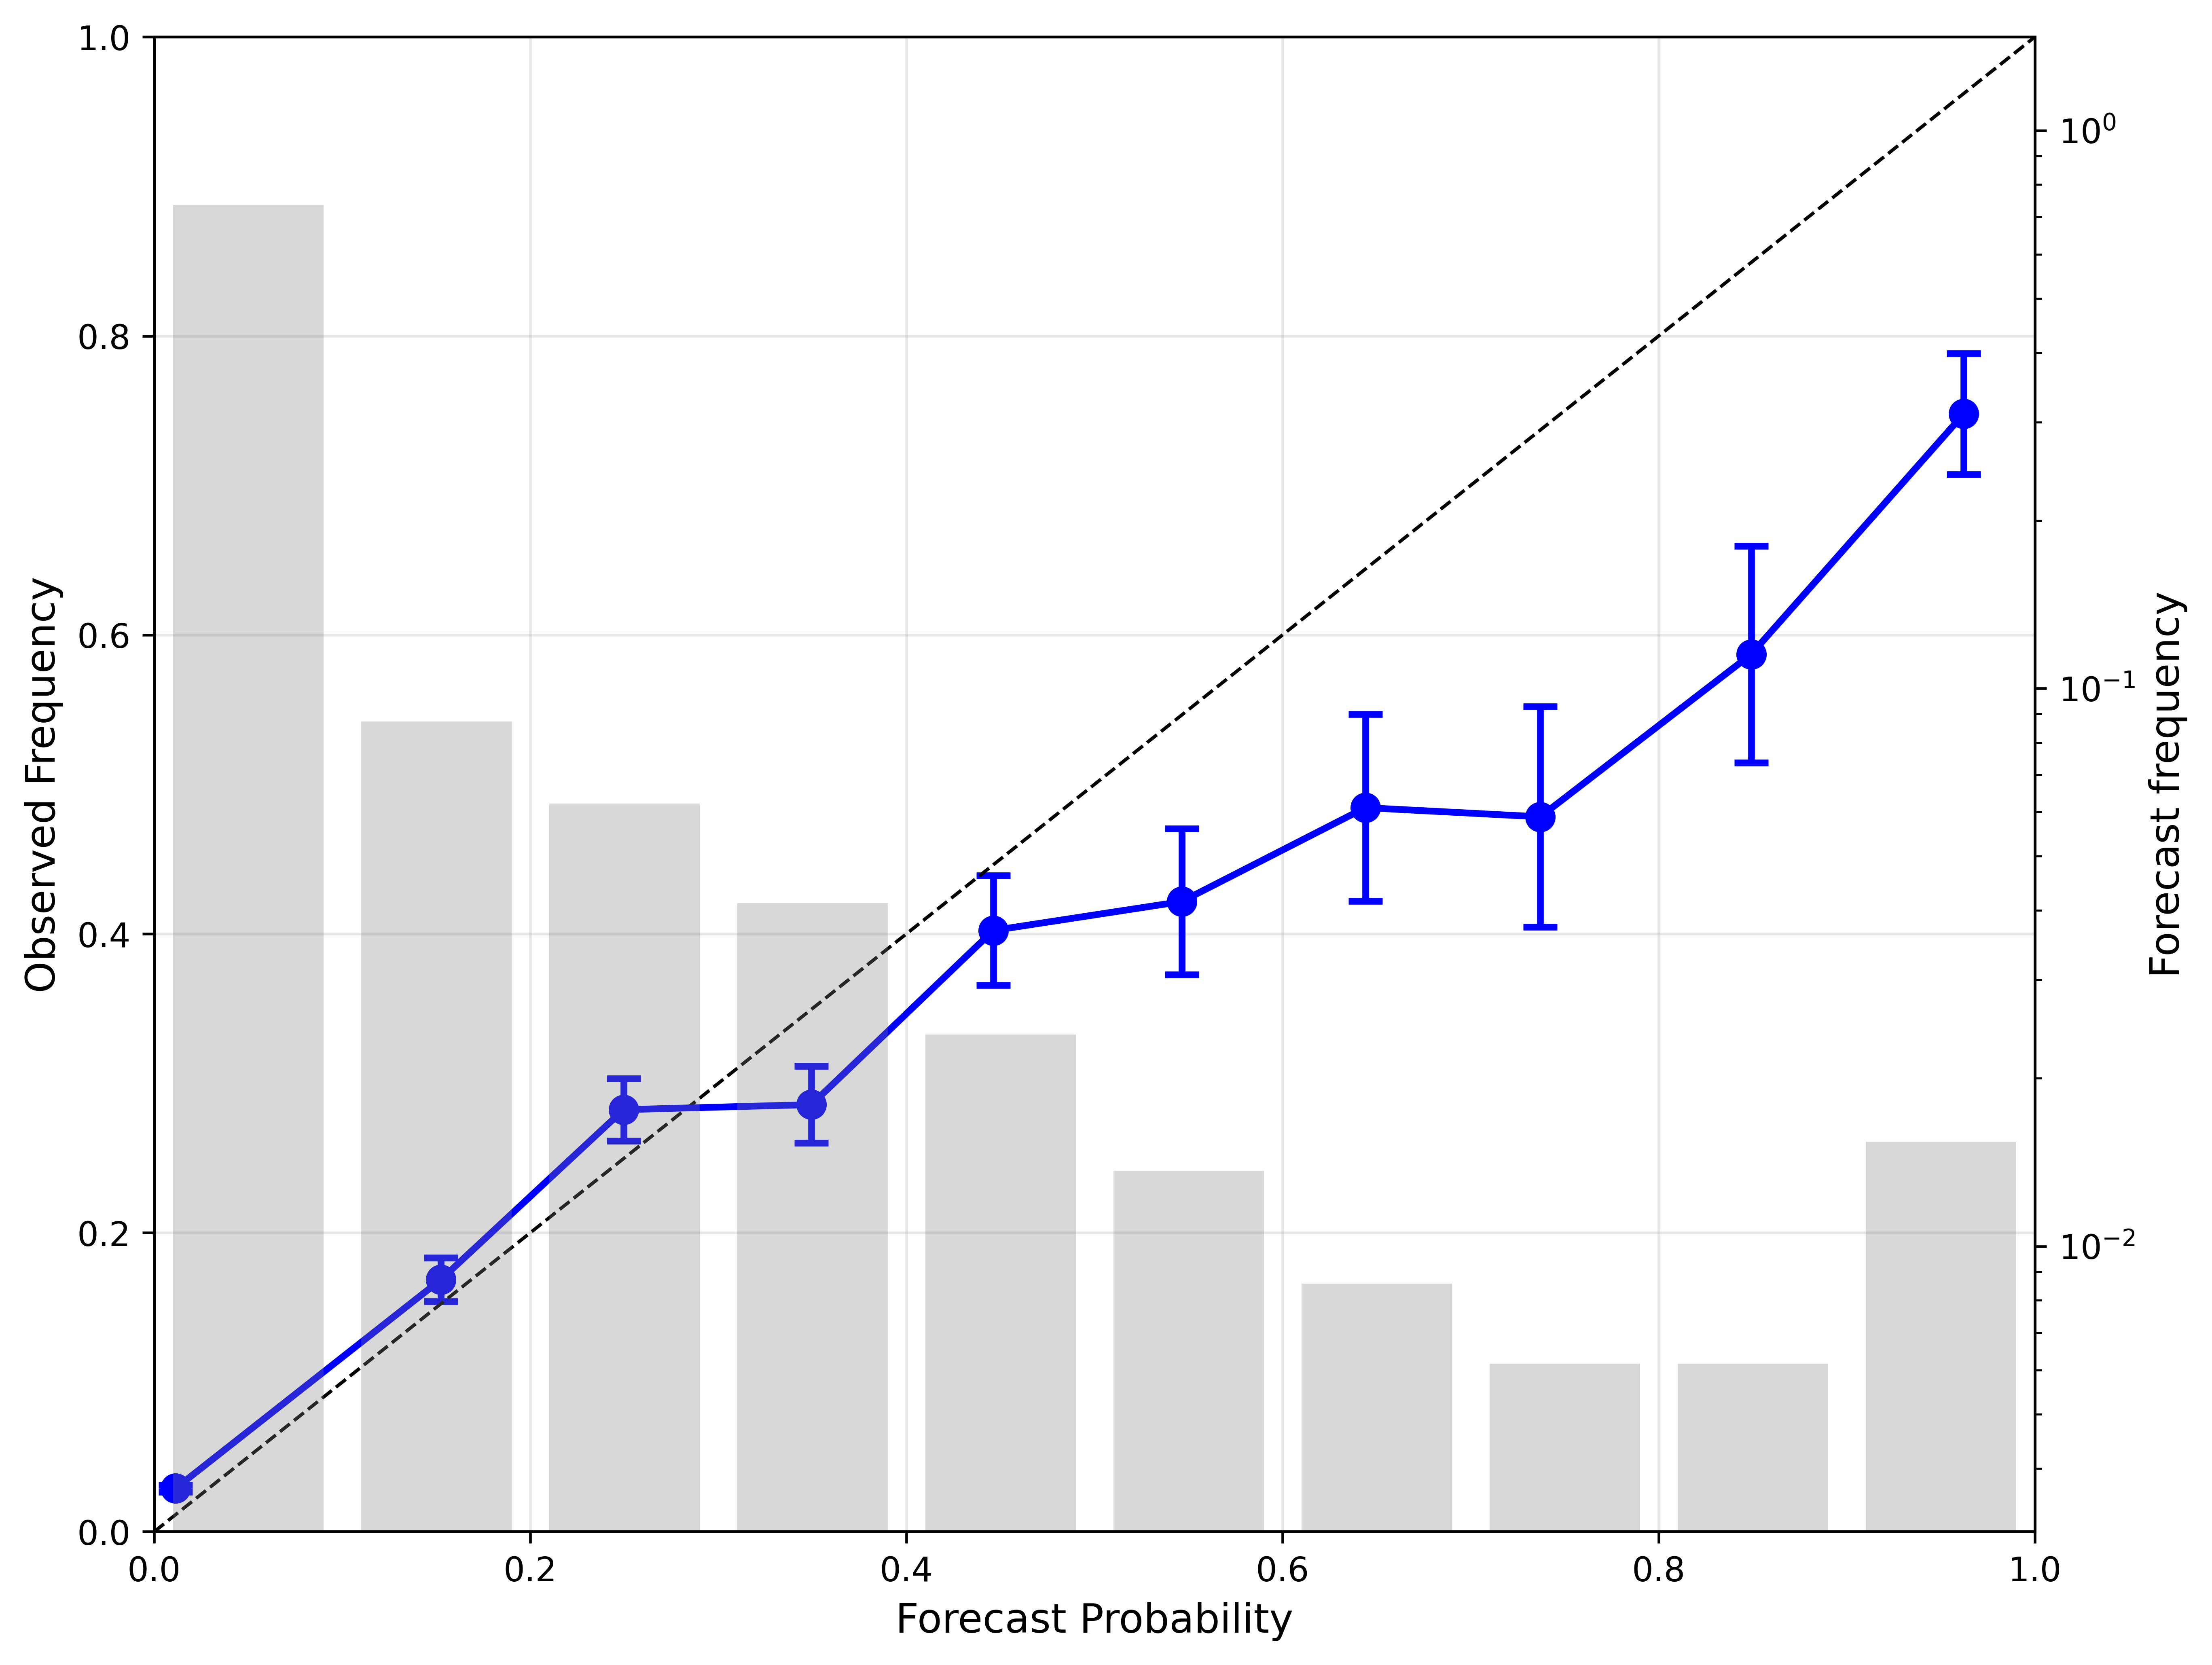

In [1]:
from IPython.display import Image, display

display(Image("reliability_output/reliability_15day.png"))

### 2. Reliability Results (CSV)

- Filename: 
  - reliability_results_{max_forecast_day}day_mok.csv (with MOK filter) or 
  - reliability_results_{max_forecast_day}day_no_mok.csv (without MOK filter)

- Columns:
  - Bin_Range: Probability bin range (e.g., "0.0-0.1")
  - N_Forecasts: Number of forecasts in bin
  - Mean_Forecast_Prob: Average forecast probability in bin
  - Observed_Frequency: Actual occurrence rate
  - Frequency: Relative frequency of forecasts in bin
  - Error_Bar: Confidence interval

## Bonus: What Reliability Analysis Measures (in case you are curious)?

Reliability analysis checks **how well forecast probabilities
match observed frequencies**.
For all forecast probabilities $ p $,

$$
P(\text{event occurs} \mid \text{forecast} = p) = p
$$

Example:
If the model predicts a **60% chance of rain**, does it actually
rain about 60% of the time?
To test that, we need to group (or “bin”) forecasts that had similar predicted probabilities, and compare their outcomes.

#### What a “probability bin range” is:

A **probability bin range** defines an interval (range) of forecast probabilities — for example:

| Bin range | Meaning |
|------------|----------|
| [0.0, 0.1) | forecasts between 0 % and 10 % |
| [0.1, 0.2) | forecasts between 10 % and 20 % |
| ... | ... |
| [0.9, 1.0] | forecasts between 90 % and 100 % |

Each bin collects all forecasts whose predicted probabilities fall inside that range.
Then we plot forecast probability (x-axis) vs observed frequency (y-axis).
If the points lie near the 1:1 diagonal, our forecast is well-calibrated (reliable).